In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

2024-11-03 12:57:10.269581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 12:57:11.371422: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-11-03 12:57:11.371583: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-11-03 12:57:11.375150: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
Dropped Escape call with ulEscapeCode : 0x03007703
Dropped Escape call with ulEscapeCode : 0x03007703
2024-11-03 12:57:14.438522: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


In [2]:
def plot_history(history):
    # Get the training and validation accuracy and loss from the history object
    acc = history.history['cyclic_mean_absolute_percentage_error']
    val_acc = history.history['val_cyclic_mean_absolute_percentage_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 6))

    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def cyclic_mean_squared_error(y_true, y_pred):
    # Convert y_true and y_pred to radians (scale 0 to 2*pi)
    y_true_rad = y_true * 2 * np.pi
    y_pred_rad = y_pred * 2 * np.pi
    
    # Calculate angular distance, taking cyclicity into account
    angle_diff = tf.math.floormod(y_pred_rad - y_true_rad + np.pi, 2 * np.pi) - np.pi
    
    # Mean squared error based on cyclic angular difference
    return tf.reduce_mean(tf.square(angle_diff))

def cyclic_mean_absolute_percentage_error(y_true, y_pred):
    y_true_rad = y_true * 2 * np.pi
    y_pred_rad = y_pred * 2 * np.pi
    angle_diff = tf.math.floormod(y_pred_rad - y_true_rad + np.pi, 2 * np.pi) - np.pi
    
    # Calculate percentage relative to the full cycle (2π)
    return tf.reduce_mean(tf.abs(angle_diff) / (2 * np.pi))


In [ ]:
dataset = 'clock75' # 'clock75' or 'clock150'
if dataset == 'clock75':
    path = 'data/clock75'
    num_classes = 75
elif dataset == 'clock150':
    path = 'data/clock150'
    num_classes = 150

images = np.load(path+'/images.npy')
labels = np.load(path+'/labels.npy')

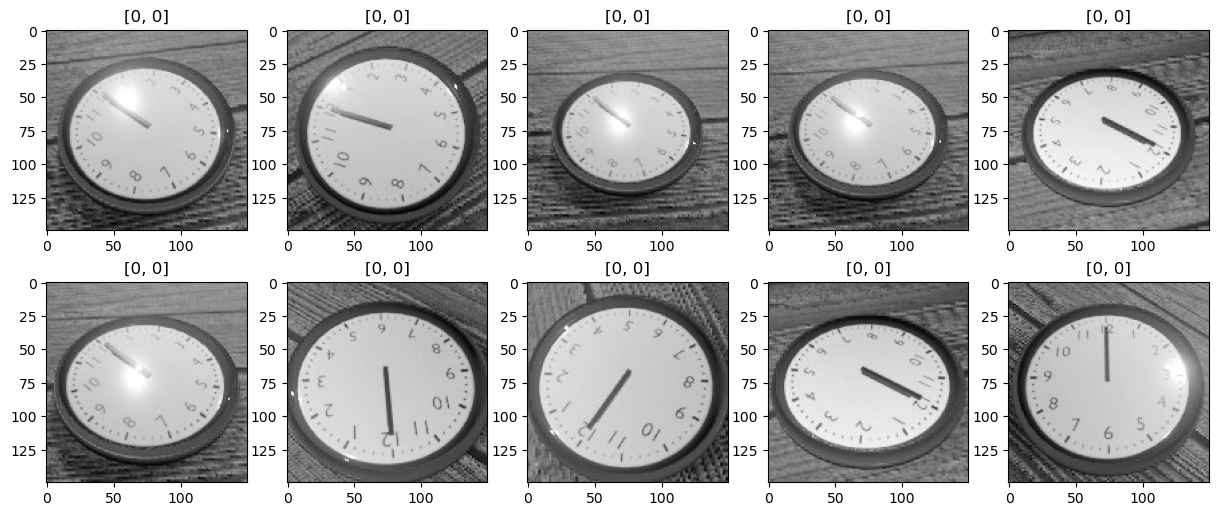

In [4]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    axs[i // 5, i % 5].imshow(images[i], cmap='gray')
    axs[i // 5, i % 5].set_title(list(labels[i]))
plt.show()

In [5]:
def class_to_num(labels):
    return labels[:, 0]+ labels[:, 1]/60

def num_to_class(numbers):
    hours = np.floor(numbers)
    minutes = (numbers - hours) * 60
    return np.stack([hours, minutes], axis=1)

def class_to_int(labels):
    return labels[:, 0]*60 + labels[:, 1]

#convert labels for regression
labels_num = class_to_num(labels)
#normalize labels
labels_num = labels_num / 12

#convert labels for classification
labels_int = class_to_int(labels)

In [6]:
#shuffle data
np.random.seed(42)
idx = np.random.permutation(len(images))
images = images[idx]
labels = labels[idx]
labels_num = labels_num[idx]
labels_int = labels_int[idx]

#split data
split = int(0.8 * len(images))
x_train, x_test = images[:split], images[split:]
y_train_og, y_test_og = labels[:split], labels[split:]
y_train_int, y_test_int = labels_int[:split], labels_int[split:]
y_train_num, y_test_num = labels_num[:split], labels_num[split:]

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

img_rows, img_cols = images.shape[1], images.shape[2]
batch_size = 64
# num_classes = 720//5

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# if num_classes == 144:
#     y_train_int = y_train_int // 5
#     y_test_int = y_test_int // 5

# # convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train_int, num_classes)
# y_test = keras.utils.to_categorical(y_test_int, num_classes)
y_train = y_train_num
y_test = y_test_num
print('y_train shape:', y_train.shape)

x_train shape: (14400, 150, 150, 1)
14400 train samples
3600 test samples
y_train shape: (14400,)


In [8]:
#create model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,
                 kernel_regularizer=keras.regularizers.l2(0.001),
                 bias_regularizer=keras.regularizers.l2(0.001),
                 activity_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))


model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.001),
                 bias_regularizer=keras.regularizers.l2(0.001),
                 activity_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))


model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.001),
                 bias_regularizer=keras.regularizers.l2(0.001),
                 activity_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(GlobalAveragePooling2D())

# model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation='linear'))

model.compile(loss=cyclic_mean_squared_error,
                optimizer='adam',
                metrics=[cyclic_mean_absolute_percentage_error])

print(model.summary())

2024-11-03 12:57:16.127456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 12:57:16.128751: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6650 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2024-11-03 12:57:17.708013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-03 12:57:17.708055: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2024-11-03 12:57:17.708078: I tensorflow/core/c

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       2

In [9]:
epochs=20
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.125)

score = model.evaluate(x_test, y_test, verbose=0)

2024-11-03 12:57:18.073189: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1134000000 exceeds 10% of free system memory.
2024-11-03 12:57:23.102784: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1134000000 exceeds 10% of free system memory.


Epoch 1/20


2024-11-03 12:57:27.090041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-03 12:57:27.382107: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-03 12:57:27.382192: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13943 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-03 12:57:27.438514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-03 12:57:27.438578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

197/197 [==============================] - ETA: 0s - loss: 7.7215 - cyclic_mean_absolute_percentage_error: 0.2524

2024-11-03 12:57:40.780315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-03 12:57:40.831698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-03 12:57:40.832849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13943 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-03 12:57:40.852342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-03 12:57:40.852403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

197/197 [==============================] - 15s 67ms/step - loss: 7.7215 - cyclic_mean_absolute_percentage_error: 0.2524 - val_loss: 3.4611 - val_cyclic_mean_absolute_percentage_error: 0.2489
Epoch 2/20
197/197 [==============================] - 13s 64ms/step - loss: 3.5489 - cyclic_mean_absolute_percentage_error: 0.2488 - val_loss: 3.4722 - val_cyclic_mean_absolute_percentage_error: 0.2489
Epoch 3/20
197/197 [==============================] - 12s 63ms/step - loss: 3.4957 - cyclic_mean_absolute_percentage_error: 0.2513 - val_loss: 3.4596 - val_cyclic_mean_absolute_percentage_error: 0.2518
Epoch 4/20
197/197 [==============================] - 13s 64ms/step - loss: 3.4441 - cyclic_mean_absolute_percentage_error: 0.2482 - val_loss: 3.4591 - val_cyclic_mean_absolute_percentage_error: 0.2513
Epoch 5/20
197/197 [==============================] - 13s 64ms/step - loss: 3.3965 - cyclic_mean_absolute_percentage_error: 0.2472 - val_loss: 3.4524 - val_cyclic_mean_absolute_percentage_error: 0.2513
E

2024-11-03 13:01:38.365515: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 324000000 exceeds 10% of free system memory.
2024-11-03 13:01:38.996075: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 324000000 exceeds 10% of free system memory.


In [10]:
print(score)

[3.3985238075256348, 0.25209397077560425]


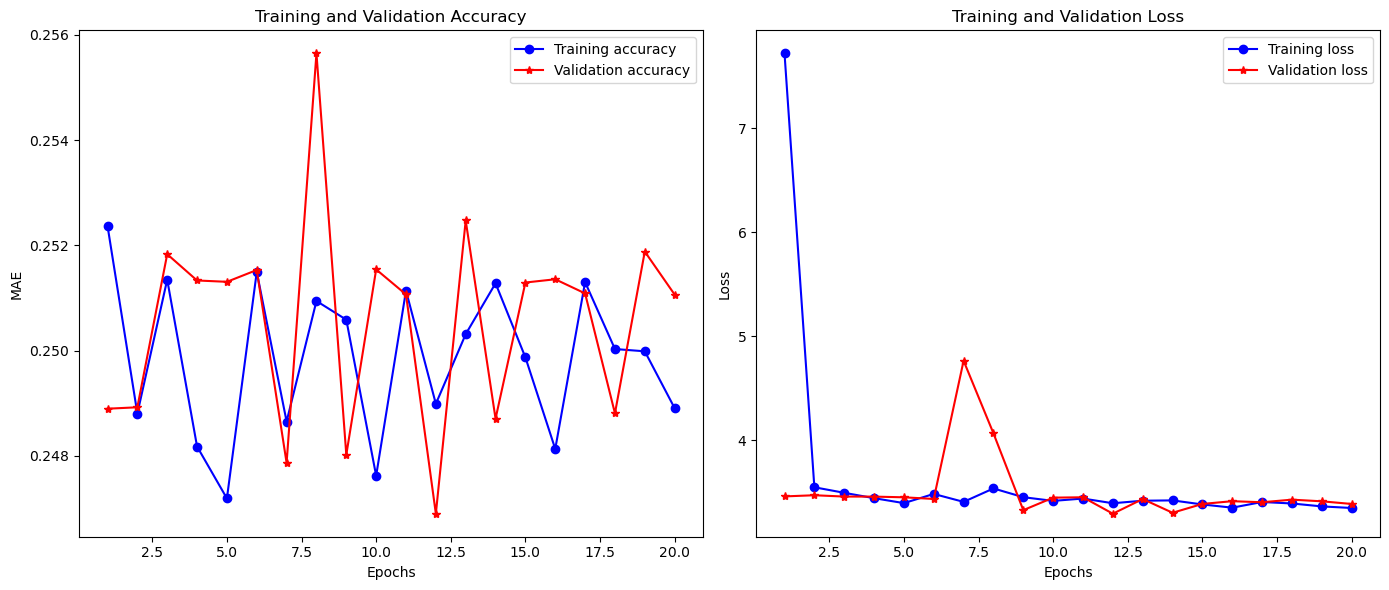

In [11]:
plot_history(history)